# Heterogeneous Task Vectors

Task Vectors are an emerging research direction, thanks to
 a very simple yet useful and practical intuition.

 A Task Vector is a vector that encodes the difference
 between neural network parameters optimized for different
 tasks.



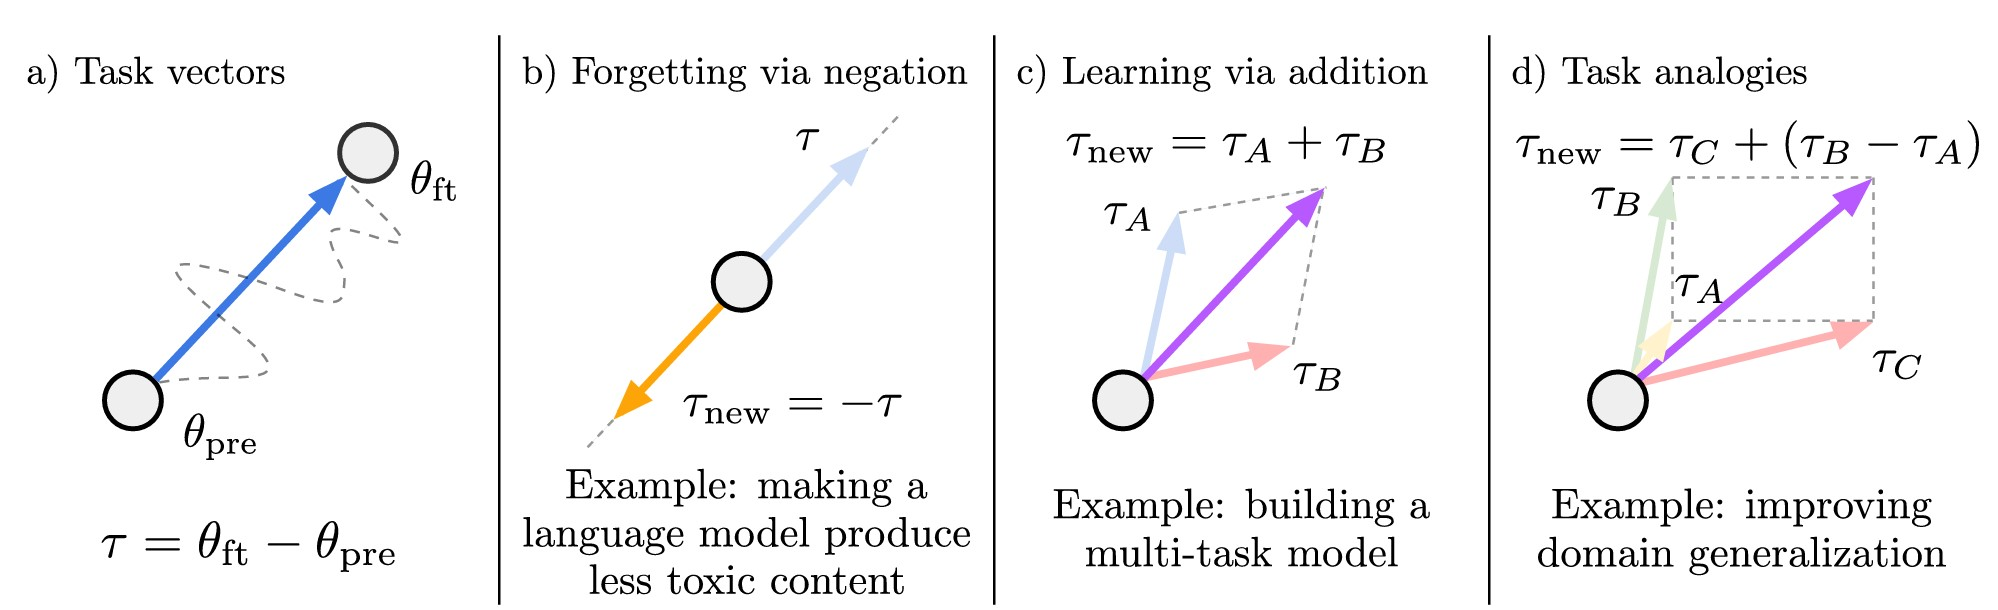

This formulation of Task Vectors obviously requires 1:1 matching architectures to work, so the
 goal of this project is to overcome this limitation:
 1. Reproduce one experiment shown in the paper for each application shown in Figure 1
 using heterogeneous models sharing some common part (e.g. ResNet-18 and ViT-16-B)
 and consider only that common part, whenever dealing with Task Vector-related matters.
 2. Pick and experiment from one application and try to apply elements of Modular Deep Learning to it.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.init as init
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import numpy as np
import random
import matplotlib.pyplot as plt
from transformers import BertModel
import copy


from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/Sapienza/Y1/DL & AAI/Project
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Mounted at /content/drive
/content/drive/MyDrive/Sapienza/Y1/DL & AAI/Project


# Architectures

In [ ]:
class ResnetClassifier(nn.Module):
  def __init__(self, out_size=100, initialize="xavier"):
    super(ResnetClassifier, self).__init__()
    self.pretrained_model = models.resnet18(pretrained=True)
    self.LN = nn.LayerNorm(1000)
    self.fc = nn.Linear(1000, out_size)

    if initialize == "kaiming":
      init.kaiming_uniform_(self.fc.weight, mode='fan_out')
      init.constant_(self.fc.bias, 0)
    if initialize == "xavier":
      init.xavier_uniform_(self.fc.weight)
      init.constant_(self.fc.bias, 0)


  def forward(self, x):
      x = self.pretrained_model(x)
      x = self.LN(x)
      x = self.fc(x)
      return x

  def forward_backbone(self, x):
      x = self.pretrained_model(x)
      return x



class ResnetFingerphotoRecognizer(nn.Module):
  def __init__(self, num_classes=100, hidden_size=128, initialize="xavier"):
    super(ResnetFingerphotoRecognizer, self).__init__()
    self.conv_1to3 = nn.Conv2d(1, 3, kernel_size=1, stride=1, padding=0)
    self.pretrained_model = models.resnet18(pretrained=True)
    self.intermediate_norm = nn.LayerNorm(1000)
    self.projector = nn.Linear(1000, hidden_size)
    self.final_norm = nn.LayerNorm(hidden_size)
    self.dropout = nn.Dropout(0.2)
    self.activation = nn.GELU()
    self.fc = nn.Linear(hidden_size, num_classes)
    self.softmax = nn.Softmax(dim=1)

    if initialize == "kaiming":
      init.kaiming_uniform_(self.projector.weight, mode='fan_in', nonlinearity='leaky_relu')
      init.kaiming_uniform_(self.fc.weight, mode='fan_out')
      init.constant_(self.fc.bias, 0)
    if initialize == "xavier":
      init.xavier_uniform_(self.projector.weight)
      init.xavier_uniform_(self.fc.weight)
      init.constant_(self.fc.bias, 0)


  def forward(self, x):
      if x.size()[1] == 1:
        x = self.conv_1to3(x)
      x = self.pretrained_model(x)
      x = self.intermediate_norm(x)
      x = self.projector(x)
      x = self.final_norm(x)
      x = self.activation(x)
      x = self.dropout(x)
      x = self.fc(x)
      x = self.softmax(x)
      return x
  def forward_logits(self, x):
      if x.size()[1] == 1:
        x = self.conv_1to3(x)
      x = self.pretrained_model(x)
      x = self.intermediate_norm(x)
      #x = self.activation(x)
      x = self.projector(x)
      x = self.final_norm(x)
      x = self.activation(x)
      x = self.dropout(x)
      x = self.fc(x)
      return x
  def forward_projector(self, x):
      if x.size()[1] == 1:
        #print("applied conv 1 to 3")
        x = self.conv_1to3(x)
      x = self.pretrained_model(x)
      x = self.intermediate_norm(x)
      x = self.projector(x)
      return x

  def forward_backbone(self, x):
      if x.size()[1] == 1:
        x = self.conv_1to3(x)
      x = self.pretrained_model(x)
      return x



class CombinedModel(nn.Module):
    def __init__(self, out_size_classfier=10, out_size_recognizer=100, hidden_size=128, initialize="xavier"):
        super(CombinedModel, self).__init__()
        self.conv_1to3 = nn.Conv2d(1, 3, kernel_size=1, stride=1, padding=0)
        self.pretrained_model = models.resnet18(pretrained=True)


        # Head for ResnetFingerphotoRecognizer
        self.intermediate_norm = nn.LayerNorm(1000)
        self.projector = nn.Linear(1000, hidden_size)
        self.final_norm = nn.LayerNorm(hidden_size)
        self.dropout = nn.Dropout(0.2)
        self.activation = nn.GELU()
        self.fc2 = nn.Linear(hidden_size, out_size_recognizer)


        # Head for ResnetClassifier
        self.LN1 = nn.LayerNorm(1000)
        self.fc1 = nn.Linear(1000, out_size_classfier)

        if initialize == "kaiming":
            init.kaiming_uniform_(self.fc1.weight, mode='fan_out')
            init.constant_(self.fc1.bias, 0)
            init.kaiming_uniform_(self.projector.weight, mode='fan_in', nonlinearity='leaky_relu')
            init.kaiming_uniform_(self.fc2.weight, mode='fan_out')
            init.constant_(self.fc2.bias, 0)
        if initialize == "xavier":
            init.xavier_uniform_(self.fc1.weight)
            init.constant_(self.fc1.bias, 0)
            init.xavier_uniform_(self.projector.weight)
            init.xavier_uniform_(self.fc2.weight)
            init.constant_(self.fc2.bias, 0)

    def forward_resnet_classifier(self, x):
        #print("Called classifier.")
        if x.size()[1] == 1:
            x = self.conv_1to3(x)
        x = self.pretrained_model(x)
        x = self.LN1(x)
        x = self.fc1(x)
        return x

    def forward_resnet_fingerphoto_recognizer(self, x):
        #print("Called fingerphoto recognizer.")
        if x.size()[1] == 1:
            x = self.conv_1to3(x)
        x = self.pretrained_model(x)
        x = self.intermediate_norm(x)
        x = self.projector(x)
        return x


    def forward(self, x, task='classification'):
        if task == 'classification':
            return self.forward_resnet_classifier(x)
        elif task == 'fingerphoto recognition':
            return self.forward_resnet_fingerphoto_recognizer(x)
        else:
            raise ValueError("Invalid task name. Choose 'classifier' or 'fingerphoto_recognizer'.")

# Example usage:
# model = CombinedModel(num_classes1=100, num_classes2=100, hidden_size=256, initialize="xavier")
# output1 = model(input, task='classifier')
# output2 = model(input, task='fingerphoto_recognizer')


# General Helper Functions

In [ ]:
# This function requires that checkpoint_model_path is a path of a model, not a state_dict!
def partial_load(main_model, checkpoint_model_path, source_param_names, target_param_names):
  """
    main_model: the model onto which we want to partially load parameters (E.g. pretrained model)
    checkpoint_model_path: the path to the .pth model we want to partially load, it must be a model file, not a state_dict
    source_param_names: a list of parameter names of the "main model", the ones we want to replace
    target_param_names: a list of parameter names of the checkpoint model, the weights we want to load
  """

  checkpoint = torch.load(checkpoint_model_path, map_location=torch.device(device))
  checkpoint.eval()
  checkpoint_params = dict(checkpoint.named_parameters())

  if not target_param_names:
    target_param_names = source_param_names

  with torch.no_grad():
    for (source_param, target_param) in zip(source_param_names, target_param_names):
      for name, par in main_model.named_parameters(): # I know it's a bad implementation but it's not the priority now
        if name == source_param:
          par.copy_(checkpoint_params[target_param])
          print("Loaded: ", name)


def get_weight_matrix(model, layer_name):
    """
    Get the weight matrix of a specific layer by name.

    Args:
    - model: The PyTorch model
    - layer_name: Name of the layer whose weight matrix is needed

    Returns:
    - The weight matrix tensor or None if not found
    """
    for name, param in model.named_parameters():
        if name == layer_name:
            return param
    return "No Layer Name Found!"

def are_tensors_equal(tensor1, tensor2, tol=1e-6):
    """
    Check if two tensors are equal within some tolerance.

    Parameters:
    tensor1 (torch.Tensor): First tensor to compare.
    tensor2 (torch.Tensor): Second tensor to compare.
    tol (float): Tolerance for the comparison. Default is 1e-6.

    Returns:
    bool: True if tensors are equal within the given tolerance, False otherwise.
    """
    if tensor1.shape != tensor2.shape:
        return False
    return torch.allclose(tensor1, tensor2, atol=tol, rtol=0)


# It takes two architecturally identical models and returns pretrained - finetuned in a dictionary
def get_task_vector(pretrained, finetuned):
  assert type(pretrained) == type(finetuned)

  TV = {} # a dictionary where KEYS = weight matrices and VALUES = (finetuned weights - pretrained weights)
  for (name, pretrained_param), (_, fine_tuned_param) in zip(pretrained.named_parameters(), finetuned.named_parameters()):
      TV[name] = fine_tuned_param.data - pretrained_param.data

  return TV


def are_models_equal(model1, model2, tol=1e-6):
    """
    Check if two PyTorch models have identical weights within some tolerance.

    Parameters:
    model1 (torch.nn.Module): First model to compare.
    model2 (torch.nn.Module): Second model to compare.
    tol (float): Tolerance for the comparison. Default is 1e-6.

    Returns:
    bool: True if models have identical weights within the given tolerance, False otherwise.
    """
    model1_params = list(model1.parameters())
    model2_params = list(model2.parameters())

    if len(model1_params) != len(model2_params):
        return False

    for p1, p2 in zip(model1_params, model2_params):
        if not torch.allclose(p1, p2, atol=tol):
            return False

    return True


def are_models_equal(model1, model2):
  for (name, par), (name2, par2) in zip(model1.named_parameters(), model2.named_parameters()):
    if(name != name2):
      print("Names not equal!")
      print(name, "   ",name2)
      return False
    if not are_tensors_equal(par, par2):
      print("Weights not equal!")
      print(name, "   ",name2)
      return False
  return True


# Forgetting via Negation
One more is ResNet18+FC finetuned for 10-class classification on CIFAR10, the other is also ResNet18+FC but finetuned for 2-class classification (dog, non-dog).

In this experiment, we take the task vector of the model trained to recognize dogs in CIFAR10 and subtract that from the task vector of the standard CIFAR10 task vector. Specifically, we do *pretrained_weights + CIFAR10_TV - dog_TV*.

We would expect the resulting model to unlearn dog classification while maintaining some capability on the rest of the classes.

### Load Task Vectors

In [ ]:
CIFAR10_TV = torch.load('task vectors/CIFAR10_TV.pth', map_location=torch.device(device))
CIFAR10_dog_TV = torch.load('task vectors/CIFAR_dog_TV.pth', map_location=torch.device(device))

### Task Vector Arithmetics

In [ ]:
# We apply task vector arithmetics only on the common backbone ResNet18
unlearn_dog_TV = {}
for name, _ in zip(CIFAR10_TV, CIFAR10_dog_TV):
    unlearn_dog_TV[name] = CIFAR10_TV[name] - CIFAR10_dog_TV[name] # compute the taask vector via subtraction

## Evaluation on CIFAR10
We load the standard CIFAR10 classifier and replace its backbone ResNet18 with the above model. Essentially we are using the above backbone model with the final FC layer taken from the fine-tuned CIFAR10 classifier.

### Load CIFAR10 Test set

In [ ]:
# Load CIFAR-10 dataset
transform = transforms.Compose([
    transforms.Resize(224),  # Resize images to 224x224 as expected by ResNet-18
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=516, shuffle=False, num_workers=2)

Files already downloaded and verified


### Evaluation Function

In [ ]:
# Evaluation
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
def eval_CIFAR10(model):
    model.eval()
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            for i in range(len(labels)):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1

    accuracies = []
    for i in range(10): # for each class
        accuracies.append(100 * class_correct[i] / class_total[i])
        #print(f'Accuracy of {classes[i]}: {100 * class_correct[i] / class_total[i]:.2f}%')

    # Overall accuracy
    overall_accuracy = 100 * sum(class_correct) / sum(class_total)
    accuracies.append(overall_accuracy)
    #print(f'Overall Validation Accuracy: {overall_accuracy:.2f}%')

    return accuracies

### Let's Try Evaluation

In [ ]:
model = ResnetClassifier(out_size=10, initialize="xavier").to(device)

# Option 1: start from the finetuned CIFAR10 model
model=torch.load("models/CIFAR10_model.pth", map_location=torch.device(device))

# Option 2: start from the pretrained model and load the final fc layer from the fine-tuned CIFAR10 model, which is architecturally different from the fc layer of the 2-class model
# partial_load(model, checkpoint_model_path ="models/CIFAR10.pth", param_names=['fc.weight', 'fc.bias'])

alpha = 0.1
for name, original_param in model.pretrained_model.named_parameters():
    original_param.data = original_param.data + alpha*unlearn_dog_TV[name] # Add task vector to pretrained weights

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
eval_CIFAR10(model)

[84.6, 94.4, 83.6, 72.9, 89.8, 54.3, 93.2, 95.8, 97.4, 94.6, 86.06]

### Alpha Pruning
Above we evaluated the model with one alpha value. Let's visualize what happens as alpha varies.

In [ ]:
alphas = [i * 0.05 for i in range(int(1 / 0.05) + 1)]

accuracies_across_alphas = []

for alpha in alphas:
    model = ResnetClassifier(out_size=10, initialize="xavier").to(device)

    # Option 1: start from the finetuned CIFAR10 model
    model=torch.load("models/CIFAR10_model.pth", map_location=torch.device(device))

    # Option 2: start from the pretrained model and load the final fc layer from the fine-tuned CIFAR10 model, which is architecturally different from the fc layer of the 2-class model
    # partial_load(model, checkpoint_model_path ="models/CIFAR10.pth", param_names=['fc.weight', 'fc.bias'])

    for name, original_param in model.pretrained_model.named_parameters():
        original_param.data = original_param.data + alpha*unlearn_dog_TV[name] # Add task vector to pretrained weights

    this_accuracies = eval_CIFAR10(model)
    print("Alpha: {:.3f}, Accuracies: {}".format(alpha, this_accuracies))
    accuracies_across_alphas.append(this_accuracies)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Alpha:  0.0  Accuracies:  [89.1, 95.4, 85.1, 72.9, 92.7, 69.4, 96.1, 96.8, 97.2, 96.0, 89.07]
Alpha:  0.05  Accuracies:  [87.0, 95.2, 84.1, 72.8, 91.1, 62.0, 95.0, 96.8, 97.3, 95.2, 87.65]
Alpha:  0.1  Accuracies:  [84.6, 94.4, 83.6, 72.9, 89.8, 54.3, 93.2, 95.8, 97.4, 94.6, 86.06]
Alpha:  0.15000000000000002  Accuracies:  [81.7, 94.1, 81.5, 72.7, 87.2, 45.2, 91.3, 94.8, 97.1, 93.7, 83.93]
Alpha:  0.2  Accuracies:  [76.5, 92.8, 78.5, 72.4, 84.8, 34.7, 87.8, 93.5, 96.5, 91.9, 80.94]
Alpha:  0.25  Accuracies:  [71.0, 92.0, 75.2, 70.5, 83.4, 24.9, 83.6, 90.7, 96.2, 90.3, 77.78]
Alpha:  0.30000000000000004  Accuracies:  [63.9, 90.6, 70.5, 68.6, 81.7, 16.7, 76.7, 86.4, 95.0, 88.4, 73.85]
Alpha:  0.35000000000000003  Accuracies:  [56.5, 89.6, 65.8, 66.2, 79.1, 11.5, 67.5, 81.5, 93.2, 85.3, 69.62]
Alpha:  0.4  Accuracies:  [49.4, 86.7, 61.7, 62.9, 75.5, 7.0, 57.6, 76.2, 90.5, 81.8, 64.93]
Alpha:  0.45  Accuracies:  [40.3, 83.5, 56.4, 61.0, 73.6, 2.6, 48.2, 69.2, 87.0, 76.7, 59.85]
Alpha:  0.5

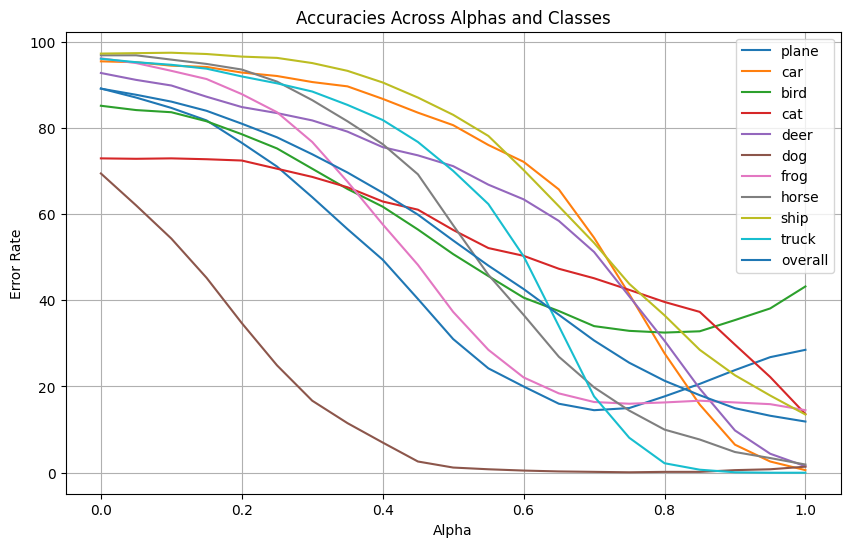

In [ ]:
import matplotlib.pyplot as plt

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck', 'overall')
transposed_list = list(map(list, zip(*accuracies_across_alphas)))

plt.figure(figsize=(10, 6))

for i, sublist in enumerate(transposed_list):
    plt.plot(alphas, sublist, label=f'{classes[i]}')


plt.xlabel('Alpha')
plt.ylabel('Error Rate')
plt.title('Accuracies Across Alphas and Classes')

# Add legend
plt.legend()

# Show the plot
plt.grid(True)  # Add grid
plt.show()

This result is expected. As we increase the subtraction coefficient (alpha) of the **unlearn_dog** task vector, the model unlearns dog classification. As can be seen, the dog accuracy degradates the fastest, while for other classes, the accuracy remained decent until alpha = 0.2. As alpha increases, the overall model performance monotonically decreases, as excessive subtraction disrupts the original parameters.

# Learning via Addition
In this experiment, we combine the fingerphoto recognizer and the CIFAR10 classifier. We apply task vector arithmetic to their common backbone ResNet18 and keep both heads. We wanna evaluate the multi-tasking abilities of the backbone on the two benchmarks.

## Model Initialization

In [ ]:
combined_model = CombinedModel(out_size_classfier=10, out_size_recognizer=128, hidden_size=128, initialize="xavier").to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Partial Loading
Let's partially load the parameters. Specifically, we load the task-specific parts from the two models. We'll later apply task aritmetics only on their common backbone.

In [ ]:
partial_load(combined_model, "models/fingerphoto_model.pth", source_param_names = ["conv_1to3.weight",
                                                                                        "conv_1to3.bias",
                                                                                        "intermediate_norm.weight",
                                                                                        "intermediate_norm.bias",
                                                                                        "projector.weight",
                                                                                        "projector.bias",
                                                                                        "final_norm.weight",
                                                                                        "final_norm.bias",
                                                                                        "fc2.weight",
                                                                                        "fc2.bias"],
                                                                  target_param_names = ["conv_1to3.weight",
                                                                                        "conv_1to3.bias",
                                                                                        "intermediate_norm.weight",
                                                                                        "intermediate_norm.bias",
                                                                                        "projector.weight",
                                                                                        "projector.bias",
                                                                                        "final_norm.weight",
                                                                                        "final_norm.bias",
                                                                                        "fc.weight",
                                                                                        "fc.bias"])

partial_load(combined_model, "models/CIFAR10_model.pth", source_param_names = ["LN1.weight",
                                                                                "LN1.bias",
                                                                                "fc1.weight",
                                                                                "fc1.bias"],
                                                          target_param_names = ["LN.weight",
                                                                                "LN.bias",
                                                                                "fc.weight",
                                                                                "fc.bias"])

Loaded:  conv_1to3.weight
Loaded:  conv_1to3.bias
Loaded:  intermediate_norm.weight
Loaded:  intermediate_norm.bias
Loaded:  projector.weight
Loaded:  projector.bias
Loaded:  final_norm.weight
Loaded:  final_norm.bias
Loaded:  fc2.weight
Loaded:  fc2.bias
Loaded:  LN1.weight
Loaded:  LN1.bias
Loaded:  fc1.weight
Loaded:  fc1.bias


## Load and Compute Task Vectors

In [ ]:
cifar_coeff = 1
fingerphoto_coeff = 1


CIFAR10_TV = torch.load('task vectors/CIFAR10_TV.pth', map_location=torch.device(device))
fingerphoto_TV = torch.load('task vectors/fingerphoto_TV.pth', map_location=torch.device(device))

multitask_TV = {}
for name, _ in zip(CIFAR10_TV, fingerphoto_TV):
    multitask_TV[name] = cifar_coeff*CIFAR10_TV[name] + fingerphoto_coeff*fingerphoto_TV[name] # We combine multi-task capability by task-vector addition




CIFAR10_TB = torch.load('task vectors/CIFAR10_TB.pth', map_location=torch.device(device))
fingerphoto_TB = torch.load('task vectors/fingerphoto_TB.pth', map_location=torch.device(device))

multitask_TB = {}
for name, _ in zip(CIFAR10_TB, fingerphoto_TB):
    multitask_TB[name] = cifar_coeff*CIFAR10_TB[name] + fingerphoto_coeff*fingerphoto_TB[name] # We combine multi-task capability by task-vector addition

## Evaluation

Next, we should evaluate our combined model on fingerphoto recognition and CIFAR10 classification. Ideally, the model should perform reasonably well on both for some good task vector coefficient.

We already wrote the code for CIFAR10 evaluation, now we shall do the same for fingerphoto recognition evaluation.

### Fingerphoto Helper Functions

In [ ]:
def create_gallery(folder_path, items):
  #items = os.listdir(test_folder_path)
  test_id_list = []
  test_imgs = []
  for item in items:
      image_path = os.path.join(folder_path, item)
      image = Image.open(image_path).convert("L")
      image = np.array(image)
      image = torch.tensor(image)
      test_imgs.append(image)
      finger_id = int(item.split("_")[0]) * int(item.split("_")[2])
      test_id_list.append(finger_id)
  test_imgs = torch.stack(test_imgs)
  test_imgs = test_imgs.unsqueeze(1)
  test_ids = torch.tensor(test_id_list)
  return test_imgs, test_ids


def get_distance_matrix(embs, d="euclidean"):
  if d == "euclidean":
    return torch.cdist(embs, embs, p=2.0)
  if d == "cosine":
    embs_normalized = F.normalize(embs, p=2, dim=1)
    return torch.mm(embs_normalized, embs_normalized.T)

### Set up

In [ ]:
import os
from PIL import Image

# For Fingerphoto Test Data
test_root_path = '/content/drive/MyDrive/Sapienza/Y1/S1/Biometric Systems/Shared Project Folder/Datasets/5. Thresholded-Then-Thinned-Test'
test_items = os.listdir(test_root_path)
test_items = sorted(test_items)


whole_gallery, _ = create_gallery(test_root_path, test_items)
whole_gallery = whole_gallery.to(device).float()



# For CIFAR-10 Test Data
transform = transforms.Compose([
    transforms.Resize(224),  # Resize images to 224x224 as expected by ResNet-18
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=256, shuffle=False, num_workers=2)

Files already downloaded and verified


In [ ]:
def get_performance(all_against_all, rank=1, d="euclidean"):
  correct = 0
  for i, row in enumerate(all_against_all):
    square_start_idx = (i//8)*8  # this is the starting index of the 8x8 square where the ith finger photo belongs, if the best score is within this square, it's correct!
    square_end_idx = square_start_idx + 8 # this is the ending index of the square
    if d=="euclidean":
      sorted_indices  = torch.argsort(row, descending=False)
    else:
      sorted_indices  = torch.argsort(row, descending=True)
    target_index = sorted_indices[rank] # this argmin_index already neglects the probe image itself, no worries
    if square_start_idx <= target_index < square_end_idx:
      correct += 1
  return correct, len(all_against_all)-correct, correct/len(all_against_all) # returns the correct, wrong, and identification rate



def eval_fingerphoto(model):
  model.eval()
  with torch.no_grad():
    output = model.forward(whole_gallery, task="fingerphoto recognition")
    eu_all_against_all = get_distance_matrix(output, d="euclidean")
    return get_performance(eu_all_against_all, rank=1, d="euclidean")[2] # let's return only the accuracy, which is the third returned item. The first two are num_correct and num_wrong and we can omit them



classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
def eval_CIFAR10_combined_model(model):
    model.eval()
    with torch.no_grad():
      class_correct = list(0. for i in range(10))
      class_total = list(0. for i in range(10))
      with torch.no_grad():
          for inputs, labels in testloader:
              inputs, labels = inputs.to(device), labels.to(device)
              outputs = model(inputs, task='classification')
              _, predicted = torch.max(outputs, 1)
              c = (predicted == labels).squeeze()
              for i in range(len(labels)):
                  label = labels[i]
                  class_correct[label] += c[i].item()
                  class_total[label] += 1

      accuracies = []
      for i in range(10): # for each class
          accuracies.append(100 * class_correct[i] / class_total[i])
          #print(f'Accuracy of {classes[i]}: {100 * class_correct[i] / class_total[i]:.2f}%')

      # Overall accuracy
      overall_accuracy = 100 * sum(class_correct) / sum(class_total)
      accuracies.append(overall_accuracy)
      #print(f'Overall Validation Accuracy: {overall_accuracy:.2f}%')

      return accuracies

In [ ]:
eval_fingerphoto(combined_model)

0.890625

### Alpha Pruning

We vary the task vector addition $alpha$ and check the performance.

In [ ]:
alphas = [i * 0.05 for i in range(int(1 / 0.05) + 1)]
#alphas = [0, 0.02, 0.04, 0.06, 0.08, 0.1, 0.12, 0.14, 0.15]
accuracies_across_alphas = []
pretrained_backbone = models.resnet18(pretrained=True).to(device) # instantiate a pretrained ResNet18

for alpha in alphas:
    for (name, target_param), (_, pretrained_param) in zip(combined_model.pretrained_model.named_parameters(), pretrained_backbone.named_parameters()):
      target_param.data.copy_(pretrained_param.data + alpha*multitask_TV[name]) # copy the task vector weights to our model's backbone

    for (name, target_buffer), (_, pretrained_buffer) in zip(combined_model.pretrained_model.named_buffers(), pretrained_backbone.named_buffers()):
      target_buffer.data.copy_(pretrained_buffer + alpha*multitask_TB[name])

    this_accuracies = [eval_CIFAR10_combined_model(combined_model)[-1]/100, eval_fingerphoto(combined_model)]
    #this_accuracies = [ eval_fingerphoto(combined_model)]

    print("Alpha: {:.3f}, Accuracies: {}".format(alpha, this_accuracies))
    accuracies_across_alphas.append(this_accuracies)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, an

Alpha: 0.000, Accuracies: [0.3097, 0.890625]
Alpha: 0.050, Accuracies: [0.28850000000000003, 0.921875]
Alpha: 0.100, Accuracies: [0.1936, 0.9427083333333334]
Alpha: 0.150, Accuracies: [0.1414, 0.890625]
Alpha: 0.200, Accuracies: [0.11599999999999999, 0.890625]
Alpha: 0.250, Accuracies: [0.102, 0.8854166666666666]
Alpha: 0.300, Accuracies: [0.0925, 0.8333333333333334]
Alpha: 0.350, Accuracies: [0.085, 0.8229166666666666]
Alpha: 0.400, Accuracies: [0.08839999999999999, 0.78125]
Alpha: 0.450, Accuracies: [0.0922, 0.7760416666666666]
Alpha: 0.500, Accuracies: [0.0949, 0.7552083333333334]
Alpha: 0.550, Accuracies: [0.0944, 0.7447916666666666]
Alpha: 0.600, Accuracies: [0.0913, 0.734375]
Alpha: 0.650, Accuracies: [0.0904, 0.7447916666666666]
Alpha: 0.700, Accuracies: [0.0964, 0.6927083333333334]
Alpha: 0.750, Accuracies: [0.1, 0.041666666666666664]
Alpha: 0.800, Accuracies: [0.1, 0.041666666666666664]
Alpha: 0.850, Accuracies: [0.1, 0.041666666666666664]
Alpha: 0.900, Accuracies: [0.1, 0.041

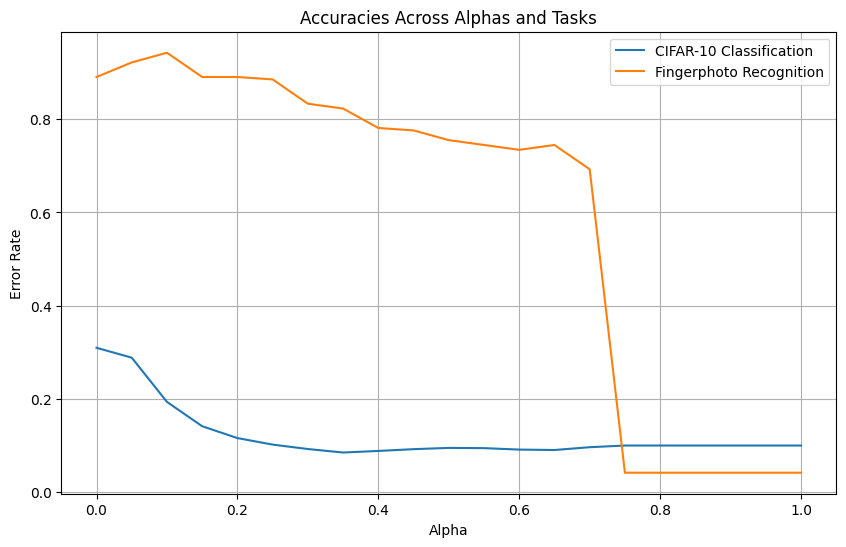

In [ ]:
classes = ('CIFAR-10 Classification', 'Fingerphoto Recognition')
transposed_list = list(map(list, zip(*accuracies_across_alphas)))

plt.figure(figsize=(10, 6))

for i, sublist in enumerate(transposed_list):
    plt.plot(alphas, sublist, label=f'{classes[i]}')


plt.xlabel('Alpha')
plt.ylabel('Error Rate')
plt.title('Accuracies Across Alphas and Tasks')

# Add legend
plt.legend()

# Show the plot
plt.grid(True)  # Add grid
plt.show()

Not so good. In the Modular Deep Learning section, we will overcome this subpar performance with a low-rank adapter.

# Analogy Learning 1 (QA-NLI)

In this section, we turn to an NLP scenario. Given two tasks t1 and t2 such that English data for t1 and t2 is abundant, Italian data for t1 is sufficient, and Italian data for t2 is scarce, we attempt to obtain an Italian model performing well on t2, without any Italian training data for t2.

Specifically, we set


*   t1: question anwering
*   t2: natural language inference


To achieve this, we fune-tune 3 checkpoints:

1.   English QA
2.   English NLI
3.   Italian QA

They share the same backbone architecture so that we can then extract task vectors from them. We assume these 3 tasks have sufficient data for fine-tuning a performance model.

Finally, we evaluate the Italian NLI model obtained by task vector analogy:

$$
TV_{\text{it_NLI}} = TV_{\text{it_QA}} + (TV_{\text{eng_NLI}} - TV_{\text{eng_QA}})
$$


## Task Vector Analogy

In [ ]:
eng_nli_TV = torch.load("task vectors/eng_nli_TV.pth")
eng_nli_TB = torch.load("task vectors/eng_nli_TB.pth")

eng_QA_TV = torch.load("task vectors/eng_QA_TV.pth")
eng_QA_TB = torch.load("task vectors/eng_QA_TB.pth")

ita_QA_TV = torch.load("task vectors/ita_QA_TV.pth")
ita_QA_TB = torch.load("task vectors/ita_QA_TB.pth")

In [ ]:
# Remove parameters of embedders, since ENG and ITA don't have the same embedder architecture
eng_QA_TV = {key: value for key, value in eng_QA_TV.items() if not key.startswith('embeddings')}
eng_QA_TB = {key: value for key, value in eng_QA_TB.items() if not key.startswith('embeddings')}

eng_nli_TV = {key: value for key, value in eng_nli_TV.items() if not key.startswith('embeddings') and not key.startswith("pooler")}
eng_nli_TB = {key: value for key, value in eng_nli_TB.items() if not key.startswith('embeddings') and not key.startswith("pooler")}

# Add the string "encoder." for parameters in the italian task vector, since it's lacking
ita_QA_TV = {"encoder."+key: value for key, value in ita_QA_TV.items()}
ita_QA_TB = {"encoder."+key: value for key, value in ita_QA_TB.items()}

In [ ]:
"""ita_nli_TV = {}

for name in eng_QA_TV.keys():
    ita_nli_TV[name] = ita_QA_TV[name] + (eng_nli_TV[name] - eng_QA_TV[name])

# No need to do that also for task buffer because it's empty


torch.save(ita_nli_TV, "task vectors/ita_nli_TV.pth")"""

In [ ]:
ita_nli_TV = torch.load("task vectors/ita_nli_TV.pth")

## Model Construction

In [ ]:
from transformers import AutoTokenizer, AutoModelForQuestionAnswering, AutoModelForSequenceClassification

In [ ]:
# instantiating other 3 models
eng_QA_model = AutoModelForQuestionAnswering.from_pretrained("AnonymousSub/bert-base-uncased_squad2.0")
eng_nli_model = AutoModelForSequenceClassification.from_pretrained("textattack/bert-base-uncased-MNLI")
ita_QA_model = AutoModelForQuestionAnswering.from_pretrained("mrm8488/bert-italian-finedtuned-squadv1-it-alfa")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/689 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/630 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/442 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at mrm8488/bert-italian-finedtuned-squadv1-it-alfa were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# The italian NLI model will have tokenizer and embedder taken from ita_QA_model, backbone BERT obtained via task vector analogy, classification head taken from eng_nli_model
tokenizer = AutoTokenizer.from_pretrained("mrm8488/bert-italian-finedtuned-squadv1-it-alfa")

pretrained_bert = BertModel.from_pretrained('bert-base-uncased')
ita_nli_model = AutoModelForSequenceClassification.from_pretrained("textattack/bert-base-uncased-MNLI") # initialize it as the eng_nli_model
ita_nli_model.bert = copy.deepcopy(pretrained_bert) # replace its bert backbone with pretrained bert
ita_nli_model.bert.embeddings = ita_QA_model.bert.embeddings # replace its embedding layers with the Italian QA model's embedding layers

tokenizer_config.json:   0%|          | 0.00/40.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/235k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
# Adding task vector to ita_nli_model
alpha = 0.5
for (name, target_param), (_, pretrained_param) in zip(ita_nli_model.bert.encoder.named_parameters(), pretrained_bert.encoder.named_parameters()):
      target_param.data.copy_(pretrained_param.data + alpha*ita_nli_TV["encoder."+name])

# No need to do the same for task buffer because it's empty

Sanity Check

In [ ]:
print("Alpha: ", alpha, "\n")

for name, par in pretrained_bert.encoder.named_parameters():
  print("Pretrained BERT: ", name)
  print(par[0][:5],"\n")
  break

for name in ita_nli_TV:
  print("ITA NLI Task Vector: ",name)
  print(ita_nli_TV[name][0][:5],"\n")
  break

for name, par in ita_nli_model.bert.encoder.named_parameters():
  print("ITA NLI BERT", name)
  print(par[0][:5],"\n")
  break

Alpha:  0.5 

Pretrained BERT:  layer.0.attention.self.query.weight
tensor([-0.0164,  0.0261, -0.0263,  0.0360, -0.0203], grad_fn=<SliceBackward0>) 

ITA NLI Task Vector:  encoder.layer.0.attention.self.query.weight
tensor([ 0.0053, -0.0239,  0.0611,  0.0868,  0.0440]) 

ITA NLI BERT layer.0.attention.self.query.weight
tensor([-0.0137,  0.0141,  0.0043,  0.0794,  0.0017], grad_fn=<SliceBackward0>) 



## Evaluation

In [ ]:
# Example premises and hypotheses
premises = [
    "Il gatto sta dormendo sul tappeto.",
    "John ha comprato una macchina nuova ieri.",
    "Sarah sta leggendo un libro in biblioteca.",
    "Il cane ha abbaiato forte in giardino.",
    "Il ristorante offre una varietà di piatti vegetariani.",
    "Il sole ha brillato tutto il giorno.",
    "Alice è andata a Parigi per le sue vacanze.",
    "Lui prende buoni voti."
]
hypotheses = [
    "Il gatto è sul tappeto.",
    "John ha una macchina nuova.",
    "Sarah ha preso in prestito un libro dalla biblioteca.",
    "Il cane ha fame.",
    "Il ristorante è costoso.",
    "Ha piovuto tutto il giorno.",
    "Alice è rimasta a casa durante le sue vacanze.",
    "Lui va malissimo a scuola."
]


# Tokenize the inputs
eng_nli_tokenizer = AutoTokenizer.from_pretrained("textattack/bert-base-uncased-MNLI")
inputs = eng_nli_tokenizer(premises, hypotheses, return_tensors='pt', padding=True, truncation=True)

# Make predictions
with torch.no_grad():
    outputs = ita_nli_model(**inputs)

# The model outputs logits, which are raw, unnormalized scores for each class (entailment, neutral, contradiction)
logits = outputs.logits
print(logits)

# Get the predicted class
predicted_class = torch.argmax(logits, dim=1)

# Class labels are typically: 0 -> entailment, 1 -> neutral, 2 -> contradiction
labels = ['contradiction', 'entailment', 'neutral']
predictions = [labels[idx] for idx in predicted_class]
#predictions = [idx for idx in predicted_class]

for i, (premise, hypothesis) in enumerate(zip(premises, hypotheses)):
    print(f"Premise: {premise}")
    print(f"Hypothesis: {hypothesis}")
    print(f"Prediction: {predictions[i]}")
    print()


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

tensor([[-0.2233, -0.1084,  0.2908],
        [-0.3477, -0.0491,  0.3419],
        [-0.2671, -0.0763,  0.2671],
        [-0.2647, -0.0518,  0.2512],
        [-0.1859, -0.1385,  0.2922],
        [-0.2202, -0.0905,  0.2572],
        [-0.2893, -0.0641,  0.3147],
        [-0.2471, -0.0599,  0.2816]])
Premise: Il gatto sta dormendo sul tappeto.
Hypothesis: Il gatto è sul tappeto.
Prediction: neutral

Premise: John ha comprato una macchina nuova ieri.
Hypothesis: John ha una macchina nuova.
Prediction: neutral

Premise: Sarah sta leggendo un libro in biblioteca.
Hypothesis: Sarah ha preso in prestito un libro dalla biblioteca.
Prediction: neutral

Premise: Il cane ha abbaiato forte in giardino.
Hypothesis: Il cane ha fame.
Prediction: neutral

Premise: Il ristorante offre una varietà di piatti vegetariani.
Hypothesis: Il ristorante è costoso.
Prediction: neutral

Premise: Il sole ha brillato tutto il giorno.
Hypothesis: Ha piovuto tutto il giorno.
Prediction: neutral

Premise: Alice è andata 

That's not good. The model is always predicting neutral.Let's try a different scenario by replacing the NLI task by sentiment analysis.

# Analogy Learning 2 (QA-SA)

The previous attempt didn't go well. Let's now replace NLI with sentiment analysis. Everything else remains the same.
$$
TV_{\text{it_SA}} = TV_{\text{it_QA}} + (TV_{\text{eng_SA
}} - TV_{\text{eng_QA}})
$$

## Task Vector Analogy

In [ ]:
eng_SA_TV = torch.load("task vectors/eng_SA_TV.pth")
eng_SA_TB = torch.load("task vectors/eng_SA_TB.pth")

eng_QA_TV = torch.load("task vectors/eng_QA_TV.pth")
eng_QA_TB = torch.load("task vectors/eng_QA_TB.pth")

ita_QA_TV = torch.load("task vectors/ita_QA_TV.pth")
ita_QA_TB = torch.load("task vectors/ita_QA_TB.pth")

In [ ]:
# Remove parameters of embedders, since ENG and ITA don't have the same embedder architecture
eng_QA_TV = {key: value for key, value in eng_QA_TV.items() if not key.startswith('embeddings')}

eng_SA_TV = {key: value for key, value in eng_SA_TV.items() if not key.startswith('embeddings') and not key.startswith("pooler")}

# Add the string "encoder." for parameters in the italian task vector, since it's lacking
ita_QA_TV = {"encoder."+key: value for key, value in ita_QA_TV.items()}

In [ ]:
"""ita_SA_TV = {}

for name in eng_QA_TV.keys():
    ita_SA_TV[name] = ita_QA_TV[name] + (eng_SA_TV[name[8:]] - eng_QA_TV[name])

# No need to do that also for task buffer because it's empty

torch.save(ita_SA_TV, "task vectors/ita_SA_TV.pth")"""

ita_SA_TV = torch.load("task vectors/ita_SA_TV.pth")

## Model Construction

In [ ]:
# Adding task vector to ita_nli_model
from transformers import AutoTokenizer, AutoModelForQuestionAnswering, AutoModelForSequenceClassification
eng_QA_model = AutoModelForQuestionAnswering.from_pretrained("AnonymousSub/bert-base-uncased_squad2.0")
eng_SA_model = AutoModelForSequenceClassification.from_pretrained("Camelia7v/bert-sentiment-analysis-model-25k-samples")
ita_QA_model = AutoModelForQuestionAnswering.from_pretrained("mrm8488/bert-italian-finedtuned-squadv1-it-alfa")

# The italian NLI model will have tokenizer and embedder taken from ita_QA_model, backbone BERT obtained via task vector analogy, classification head taken from eng_nli_model
tokenizer = AutoTokenizer.from_pretrained("mrm8488/bert-italian-finedtuned-squadv1-it-alfa")

pretrained_bert = BertModel.from_pretrained('bert-base-uncased')
ita_SA_model = AutoModelForSequenceClassification.from_pretrained("Camelia7v/bert-sentiment-analysis-model-25k-samples") # initialize it as the eng_QA_model
ita_SA_model.bert = copy.deepcopy(pretrained_bert) # replace its bert backbone with pretrained bert
ita_SA_model.bert.embeddings = ita_QA_model.bert.embeddings # replace its embedding layers with the Italian QA model's embedding layers

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/689 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/727 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/442 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at mrm8488/bert-italian-finedtuned-squadv1-it-alfa were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tokenizer_config.json:   0%|          | 0.00/40.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/235k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
alpha = 0.5
for (name, target_param), (_, pretrained_param) in zip(ita_SA_model.bert.encoder.named_parameters(), pretrained_bert.encoder.named_parameters()):
      target_param.data.copy_(pretrained_param.data + alpha*ita_SA_TV["encoder."+name])

# No need to do the same for task buffer because it's empty

print("Alpha: ", alpha, "\n")

for name, par in pretrained_bert.encoder.named_parameters():
  print("Pretrained BERT: ", name)
  print(par[0][:5],"\n")
  break

for name in ita_SA_TV:
  print("ITA NLI Task Vector: ",name)
  print(ita_SA_TV[name][0][:5],"\n")
  break

for name, par in ita_SA_model.bert.encoder.named_parameters():
  print("ITA NLI BERT", name)
  print(par[0][:5],"\n")
  break

Alpha:  0.5 

Pretrained BERT:  layer.0.attention.self.query.weight
tensor([-0.0164,  0.0261, -0.0263,  0.0360, -0.0203], grad_fn=<SliceBackward0>) 

ITA NLI Task Vector:  encoder.layer.0.attention.self.query.weight
tensor([ 0.0057, -0.0231,  0.0592,  0.0862,  0.0457]) 

ITA NLI BERT layer.0.attention.self.query.weight
tensor([-0.0136,  0.0145,  0.0033,  0.0792,  0.0025], grad_fn=<SliceBackward0>) 



## Evaluation
Now that we've obtained the training-free Italian Sentiment Analysis model, let's test it.

In [ ]:
def classify_sentences(sentences):
    # Tokenize the input sentences
    inputs = tokenizer(sentences, return_tensors='pt', padding=True, truncation=True)

    # Forward pass to get logits
    with torch.no_grad():
        outputs = ita_SA_model(**inputs)

    # Get the logits
    logits = outputs.logits

    # Apply softmax to get probabilities
    probabilities = torch.nn.functional.softmax(logits, dim=-1)

    # Get the predicted class (0 for negative, 1 for positive)
    predictions = torch.argmax(probabilities, dim=-1)

    return predictions, probabilities

In [ ]:
sentences = [
    "Mi piace questa pizza!",
    "Questo ristorante è pessimo.",
    "Va bene, nulla di troppo eccezionale.",
    "Decente."
]


predictions, probabilities = classify_sentences(sentences)


for sentence, prediction, probability in zip(sentences, predictions, probabilities):
    sentiment = "positive" if prediction == 1 else "negative"
    print(f"Sentence: {sentence}\nSentiment: {sentiment}\nProbability: {probability}\n")


Sentence: Mi piace questa pizza!
Sentiment: positive
Probability: tensor([0.4388, 0.5612])

Sentence: Questo ristorante è pessimo.
Sentiment: positive
Probability: tensor([0.4390, 0.5610])

Sentence: Va bene, nulla di troppo eccezionale.
Sentiment: positive
Probability: tensor([0.4667, 0.5333])

Sentence: Decente.
Sentiment: positive
Probability: tensor([0.4471, 0.5529])



Again, not good. The model is always predicting positive sentiment.

# Improving Learning via Addition with Modular Deep Learning

This section augments the "learning via addition" with elements from **Modular Deep Learning**, trying to overcome the poor performance of the previous naive attempt.

Idea:

1.   apply learning via addition as already did to obtain a good initialization (yet not very performant)
2.   since the CIFAR-10 performance was subpar, add a low-rank adapter before the CIFAR-10 classification head and only fine-tune that. We avoid catastrophic forgetting with respect to the other task (fingerphoto recognition) because we are not updating parameters related to that.


In [ ]:
class Adapter(nn.Module):
    def __init__(self, input_dim, output_dim, rank=1, initialize="zero", freeze=True):
        super(Adapter, self).__init__()
        self.rank = rank
        self.A = nn.Parameter(torch.randn(input_dim, rank))
        self.B = nn.Parameter(torch.randn(rank, output_dim))

        if initialize == "kaiming":
            init.kaiming_uniform_(self.A, mode='fan_in', nonlinearity='leaky_relu')
            init.kaiming_uniform_(self.B, mode='fan_in', nonlinearity='leaky_relu')
        elif initialize == "xavier":
            init.xavier_uniform_(self.A)
            init.xavier_uniform_(self.B)
        elif initialize == "zero":
            init.constant_(self.B, 0)

        if freeze:
            for param in self.parameters():
                param.requires_grad = False

    def forward(self, x):
        return x @ self.A @ self.B

In [ ]:
from torchvision import models

class AdaptiveCombinedModel(nn.Module):
    def __init__(self, out_size_classifier=10, out_size_recognizer=100, hidden_size=128, rank=4, initialize="xavier", freeze_adapter=True):
        super(AdaptiveCombinedModel, self).__init__()
        self.conv_1to3 = nn.Conv2d(1, 3, kernel_size=1, stride=1, padding=0)
        self.pretrained_model = models.resnet18(pretrained=True)

        # Head for ResnetFingerphotoRecognizer
        self.intermediate_norm = nn.LayerNorm(1000)
        self.projector = nn.Linear(1000, hidden_size)
        self.final_norm = nn.LayerNorm(hidden_size)
        self.dropout = nn.Dropout(0.2)
        self.activation = nn.GELU()
        self.fc2 = nn.Linear(hidden_size, out_size_recognizer)

        # Head for ResnetClassifier
        self.LN1 = nn.LayerNorm(1000)
        self.adapter = Adapter(1000, 1000, rank, initialize="zero", freeze=freeze_adapter)
        self.fc1 = nn.Linear(1000, out_size_classifier)

        if initialize == "kaiming":
            init.kaiming_uniform_(self.fc1.weight, mode='fan_out')
            init.constant_(self.fc1.bias, 0)
            init.kaiming_uniform_(self.projector.weight, mode='fan_in', nonlinearity='leaky_relu')
            init.kaiming_uniform_(self.fc2.weight, mode='fan_out')
            init.constant_(self.fc2.bias, 0)
        elif initialize == "xavier":
            init.xavier_uniform_(self.fc1.weight)
            init.constant_(self.fc1.bias, 0)
            init.xavier_uniform_(self.projector.weight)
            init.xavier_uniform_(self.fc2.weight)
            init.constant_(self.fc2.bias, 0)


    def forward_resnet_classifier(self, x):
        if x.size()[1] == 1:
            x = self.conv_1to3(x)
        x = self.pretrained_model(x)
        x = self.LN1(x) + self.adapter(x)
        x = self.fc1(x)
        return x

    def forward_resnet_fingerphoto_recognizer(self, x):
        if x.size()[1] == 1:
            x = self.conv_1to3(x)
        x = self.pretrained_model(x)
        x = self.intermediate_norm(x)
        x = self.projector(x)
        return x

    def forward(self, x, task='classification'):
        if task == 'classification':
            return self.forward_resnet_classifier(x)
        elif task == 'fingerphoto recognition':
            return self.forward_resnet_fingerphoto_recognizer(x)
        else:
            raise ValueError("Invalid task name. Choose 'classification' or 'fingerphoto recognition'.")

These hyperparameters are for now for illustration. Later we'll conduct a grid search over these two hyperparameters.

In [ ]:
rank = 3 # rank of CIFAR-10 adapter
alpha = 0.1 # coefficient of task vector addition

In [ ]:
adaptive_model = AdaptiveCombinedModel(out_size_classifier=10, out_size_recognizer=128, hidden_size=128, rank=rank, initialize="xavier", freeze_adapter=True).to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 106MB/s]


Load the parameters that are already trained or pretrained.

In [ ]:
partial_load(adaptive_model, "models/fingerphoto_model.pth", source_param_names = ["conv_1to3.weight",
                                                                                    "conv_1to3.bias",
                                                                                    "intermediate_norm.weight",
                                                                                    "intermediate_norm.bias",
                                                                                    "projector.weight",
                                                                                    "projector.bias",
                                                                                    "final_norm.weight",
                                                                                    "final_norm.bias",
                                                                                    "fc2.weight",
                                                                                    "fc2.bias"],
                                                              target_param_names = ["conv_1to3.weight",
                                                                                    "conv_1to3.bias",
                                                                                    "intermediate_norm.weight",
                                                                                    "intermediate_norm.bias",
                                                                                    "projector.weight",
                                                                                    "projector.bias",
                                                                                    "final_norm.weight",
                                                                                    "final_norm.bias",
                                                                                    "fc.weight",
                                                                                    "fc.bias"])

partial_load(adaptive_model, "models/CIFAR10_model.pth", source_param_names = ["LN1.weight",
                                                                                "LN1.bias",
                                                                                "fc1.weight",
                                                                                "fc1.bias"],
                                                          target_param_names = ["LN.weight",
                                                                                "LN.bias",
                                                                                "fc.weight",
                                                                                "fc.bias"])

Loaded:  conv_1to3.weight
Loaded:  conv_1to3.bias
Loaded:  intermediate_norm.weight
Loaded:  intermediate_norm.bias
Loaded:  projector.weight
Loaded:  projector.bias
Loaded:  final_norm.weight
Loaded:  final_norm.bias
Loaded:  fc2.weight
Loaded:  fc2.bias
Loaded:  LN1.weight
Loaded:  LN1.bias
Loaded:  fc1.weight
Loaded:  fc1.bias


Compute the multitask task-vector.

In [ ]:
cifar_coeff = 1
fingerphoto_coeff = 1


CIFAR10_TV = torch.load('task vectors/CIFAR10_TV.pth', map_location=torch.device(device))
fingerphoto_TV = torch.load('task vectors/fingerphoto_TV.pth', map_location=torch.device(device))

multitask_TV = {}
for name, _ in zip(CIFAR10_TV, fingerphoto_TV):
    multitask_TV[name] = cifar_coeff*CIFAR10_TV[name] + fingerphoto_coeff*fingerphoto_TV[name] # We combine multi-task capability by task-vector addition



CIFAR10_TB = torch.load('task vectors/CIFAR10_TB.pth', map_location=torch.device(device))
fingerphoto_TB = torch.load('task vectors/fingerphoto_TB.pth', map_location=torch.device(device))

multitask_TB = {}
for name, _ in zip(CIFAR10_TB, fingerphoto_TB):
    multitask_TB[name] = cifar_coeff*CIFAR10_TB[name] + fingerphoto_coeff*fingerphoto_TB[name] # We combine multi-task capability by task-vector addition

Apply the task vector and task buffer.

In [ ]:
pretrained_backbone = models.resnet18(pretrained=True).to(device) # instantiate a pretrained ResNet18

for (name, target_param), (_, pretrained_param) in zip(adaptive_model.pretrained_model.named_parameters(), pretrained_backbone.named_parameters()):
  target_param.data.copy_(pretrained_param.data + alpha*multitask_TV[name]) # copy the task vector weights to our model's backbone

for (name, target_buffer), (_, pretrained_buffer) in zip(adaptive_model.pretrained_model.named_buffers(), pretrained_backbone.named_buffers()):
  target_buffer.data.copy_(pretrained_buffer + alpha*multitask_TB[name])

In [ ]:
transform = transforms.Compose([
    transforms.Resize(224),  # Resize images to 224x224 as expected by ResNet-18
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=512, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=512, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


Preliminary evaluation. See how low is the CIFAR-10 accuracy, just 19.36%!

In [ ]:
this_accuracies = [eval_CIFAR10_combined_model(adaptive_model)[-1]/100, eval_fingerphoto(adaptive_model)]

print("Alpha: {:.3f}, Accuracies: {}".format(alpha, this_accuracies))

Alpha: 0.100, Accuracies: [0.1936, 0.9427083333333334]


Previously, we evaluated the combined_model obtained via naive task vector addition.It was performing reasonably well on fingerphoto recognition but not on CIFAR-10. Now, we will freeze the entire model but the low-rank adapter and train only the adapter on CIFAR-10 data. Instead of fine-tuning the layer norm and the fully connected classification head, training the adapter is more efficient because its rank is low.

In [ ]:
for param in adaptive_model.parameters(): # freeze all parameters
    param.requires_grad = False

"""for module in adaptive_model.pretrained_model.modules(): # freeze running statistics in batch norms (Tried it. Not recommended, it'll not learn well on CIFAR-10)
    if isinstance(module, nn.BatchNorm2d):
        module.track_running_stats = False"""


for param in adaptive_model.adapter.parameters(): # unfreeze only the low-rank adapter
    param.requires_grad = True


for name, param in adaptive_model.named_parameters():
    print(f"{name}: requires_grad={param.requires_grad}")

conv_1to3.weight: requires_grad=False
conv_1to3.bias: requires_grad=False
pretrained_model.conv1.weight: requires_grad=False
pretrained_model.bn1.weight: requires_grad=False
pretrained_model.bn1.bias: requires_grad=False
pretrained_model.layer1.0.conv1.weight: requires_grad=False
pretrained_model.layer1.0.bn1.weight: requires_grad=False
pretrained_model.layer1.0.bn1.bias: requires_grad=False
pretrained_model.layer1.0.conv2.weight: requires_grad=False
pretrained_model.layer1.0.bn2.weight: requires_grad=False
pretrained_model.layer1.0.bn2.bias: requires_grad=False
pretrained_model.layer1.1.conv1.weight: requires_grad=False
pretrained_model.layer1.1.bn1.weight: requires_grad=False
pretrained_model.layer1.1.bn1.bias: requires_grad=False
pretrained_model.layer1.1.conv2.weight: requires_grad=False
pretrained_model.layer1.1.bn2.weight: requires_grad=False
pretrained_model.layer1.1.bn2.bias: requires_grad=False
pretrained_model.layer2.0.conv1.weight: requires_grad=False
pretrained_model.layer2

We can now train the adapter only on CIFAR-10, with rank = 3 and alpha = 0.1

In [ ]:
print("We will only train the adapter, which has: ", sum(p.numel() for p in adaptive_model.adapter.parameters()), "learnable parameters.")
print("The full dense layer has: ", sum(p.numel() for p in adaptive_model.fc1.parameters()), "learnable parameters.")

We will only train the adapter, which has:  6000 learnable parameters.
The full dense layer has:  10010 learnable parameters.


In [ ]:
import torch.optim as optim
import time
from tqdm import tqdm
from torch.optim import lr_scheduler

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(adaptive_model.adapter.parameters(), lr=0.01)
scheduler = lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)

num_epochs = 1

In [ ]:
accuracy_list = []

for epoch in range(num_epochs):
    adaptive_model.train()
    running_loss = 0.0
    start_epoch_time = time.time()  # Start time for the epoch

    # Wrap the DataLoader with tqdm
    pbar = tqdm(enumerate(trainloader), total=len(trainloader), desc=f'Epoch [{epoch+1}/{num_epochs}]')

    for batch_idx, (inputs, labels) in pbar:
        batch_start_time = time.time()  # Start time for the batch

        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = adaptive_model(inputs, task='classification')
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

        batch_end_time = time.time()  # End time for the batch
        batch_duration = batch_end_time - batch_start_time

        # Update tqdm description with batch timing
        pbar.set_postfix(Batch_Time=f'{batch_duration:.2f}s', Loss=f'{loss.item():.4f}')

    scheduler.step()
    epoch_loss = running_loss / len(trainloader.dataset)
    epoch_duration = time.time() - start_epoch_time  # End time for the epoch
    print(f'Epoch [{epoch+1}/{num_epochs}] completed in {epoch_duration:.2f} seconds, Average Loss: {epoch_loss:.4f}')

    # Validation step (optional)
    adaptive_model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = adaptive_model(inputs, task='classification')
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    cifar_acc = 100 * correct / total
    fingerphoto_acc = eval_fingerphoto(adaptive_model)
    print(f'Validation Accuracy after Epoch [{epoch+1}/{num_epochs}]: {cifar_acc:.2f}%')
    print("Figerphoto Accuracy: ", fingerphoto_acc)


    accuracy_list.append((cifar_acc, fingerphoto_acc))

print('Finished Training')

Epoch [1/1]: 100%|██████████| 98/98 [02:23<00:00,  1.46s/it, Batch_Time=0.34s, Loss=0.5658]

Epoch [1/1] completed in 143.58 seconds, Average Loss: 1.7379


Validation Accuracy after Epoch [1/1]: 80.36%
Figerphoto Accuracy:  0.8333333333333334
Finished Training


## Alpha & Rank Pruning
Now, we repeat the above experiment as alpha and rank vary, and evaluate on both tasks.

In [ ]:
import json

alphas = [0.05, 0.1, 0.15, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
ranks = [1,2,3,4]
configs = [(alpha, rank) for alpha in alphas for rank in ranks]
pretrained_backbone = models.resnet18(pretrained=True).to(device) # instantiate a pretrained ResNet18
criterion = nn.CrossEntropyLoss()
accuracy_dict = {}


for (alpha, rank) in configs:

    adaptive_model = AdaptiveCombinedModel(out_size_classifier=10, out_size_recognizer=128, hidden_size=128, rank=rank, initialize="xavier", freeze_adapter=True).to(device)

    partial_load(adaptive_model, "models/fingerphoto_model.pth", source_param_names = ["conv_1to3.weight",
                                                                                        "conv_1to3.bias",
                                                                                        "intermediate_norm.weight",
                                                                                        "intermediate_norm.bias",
                                                                                        "projector.weight",
                                                                                        "projector.bias",
                                                                                        "final_norm.weight",
                                                                                        "final_norm.bias",
                                                                                        "fc2.weight",
                                                                                        "fc2.bias"],
                                                                target_param_names = ["conv_1to3.weight",
                                                                                        "conv_1to3.bias",
                                                                                        "intermediate_norm.weight",
                                                                                        "intermediate_norm.bias",
                                                                                        "projector.weight",
                                                                                        "projector.bias",
                                                                                        "final_norm.weight",
                                                                                        "final_norm.bias",
                                                                                        "fc.weight",
                                                                                        "fc.bias"])

    partial_load(adaptive_model, "models/CIFAR10_model.pth", source_param_names = ["LN1.weight",
                                                                                    "LN1.bias",
                                                                                    "fc1.weight",
                                                                                    "fc1.bias"],
                                                            target_param_names = ["LN.weight",
                                                                                    "LN.bias",
                                                                                    "fc.weight",
                                                                                    "fc.bias"])


    for (name, target_param), (_, pretrained_param) in zip(adaptive_model.pretrained_model.named_parameters(), pretrained_backbone.named_parameters()):
        target_param.data.copy_(pretrained_param.data + alpha*multitask_TV[name]) # copy the task vector weights to our model's backbone
    for (name, target_buffer), (_, pretrained_buffer) in zip(adaptive_model.pretrained_model.named_buffers(), pretrained_backbone.named_buffers()):
        target_buffer.data.copy_(pretrained_buffer + alpha*multitask_TB[name])


    for param in adaptive_model.parameters(): # freeze all parameters
        param.requires_grad = False
    for param in adaptive_model.adapter.parameters(): # unfreeze only the low-rank adapter
        param.requires_grad = True


    optimizer = optim.Adam(adaptive_model.adapter.parameters(), lr=0.01)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)
    num_epochs = 1


    for epoch in range(num_epochs):
        adaptive_model.train()
        running_loss = 0.0
        start_epoch_time = time.time()  # Start time for the epoch
        cifar_acc_sum = 0
        fingerphoto_acc_sum = 0

        # Wrap the DataLoader with tqdm
        pbar = tqdm(enumerate(trainloader), total=len(trainloader), desc=f'Epoch [{epoch+1}/{num_epochs}]')

        for batch_idx, (inputs, labels) in pbar:
            batch_start_time = time.time()  # Start time for the batch

            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = adaptive_model(inputs, task='classification')
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

            batch_end_time = time.time()  # End time for the batch
            batch_duration = batch_end_time - batch_start_time

            # Update tqdm description with batch timing
            pbar.set_postfix(Batch_Time=f'{batch_duration:.2f}s', Loss=f'{loss.item():.4f}')

        scheduler.step()
        epoch_loss = running_loss / len(trainloader.dataset)
        epoch_duration = time.time() - start_epoch_time  # End time for the epoch
        print(f'Epoch [{epoch+1}/{num_epochs}] completed in {epoch_duration:.2f} seconds, Average Loss: {epoch_loss:.4f}')

        # Validation step (optional)
        adaptive_model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in testloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = adaptive_model(inputs, task='classification')
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        cifar_acc = 100 * correct / total
        fingerphoto_acc = eval_fingerphoto(adaptive_model)

        cifar_acc_sum += cifar_acc
        fingerphoto_acc_sum += fingerphoto_acc

        print(f'Validation Accuracy after Epoch [{epoch+1}/{num_epochs}]: {cifar_acc:.2f}%')
        print("Figerphoto Accuracy: ", fingerphoto_acc)


    accuracy_dict[str(alpha) + " - " +str(rank)] = (cifar_acc/num_epochs, fingerphoto_acc/num_epochs)
    print("Current accuracy dict: ", accuracy_dict)

    with open("alpha_rank_pruning.json", "w") as f:
        json.dump(accuracy_dict, f)

    print('Done for configuration: ', alpha, rank)

In [ ]:
accuracy_dict

{'0.05 - 1': (66.13, 0.7708333333333334),
 '0.05 - 2': (67.38, 0.78125),
 '0.05 - 3': (64.08, 0.7708333333333334),
 '0.05 - 4': (67.0, 0.796875),
 '0.1 - 1': (81.19, 0.8385416666666666),
 '0.1 - 2': (80.65, 0.8385416666666666),
 '0.1 - 3': (81.52, 0.8385416666666666),
 '0.1 - 4': (80.61, 0.84375),
 '0.15 - 1': (87.34, 0.84375),
 '0.15 - 2': (88.08, 0.84375),
 '0.15 - 3': (86.99, 0.84375),
 '0.15 - 4': (86.47, 0.8385416666666666),
 '0.2 - 1': (90.55, 0.8229166666666666),
 '0.2 - 2': (90.46, 0.828125),
 '0.2 - 3': (90.2, 0.828125),
 '0.2 - 4': (89.72, 0.828125),
 '0.3 - 1': (92.79, 0.8333333333333334),
 '0.3 - 2': (93.04, 0.8385416666666666),
 '0.3 - 3': (91.63, 0.8333333333333334),
 '0.3 - 4': (91.74, 0.84375),
 '0.4 - 1': (93.83, 0.8385416666666666),
 '0.4 - 2': (93.68, 0.84375),
 '0.4 - 3': (92.08, 0.84375),
 '0.4 - 4': (92.67, 0.84375),
 '0.5 - 1': (94.07, 0.8333333333333334),
 '0.5 - 2': (94.09, 0.8229166666666666),
 '0.5 - 3': (93.64, 0.8177083333333334),
 '0.5 - 4': (92.14, 0.8229

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Let's save the results explicitly to avoid losing it
accuracy_dict = {'0.05 - 1': (66.13, 0.7708333333333334),
                '0.05 - 2': (67.38, 0.78125),
                '0.05 - 3': (64.08, 0.7708333333333334),
                '0.05 - 4': (67.0, 0.796875),
                '0.1 - 1': (81.19, 0.8385416666666666),
                '0.1 - 2': (80.65, 0.8385416666666666),
                '0.1 - 3': (81.52, 0.8385416666666666),
                '0.1 - 4': (80.61, 0.84375),
                '0.15 - 1': (87.34, 0.84375),
                '0.15 - 2': (88.08, 0.84375),
                '0.15 - 3': (86.99, 0.84375),
                '0.15 - 4': (86.47, 0.8385416666666666),
                '0.2 - 1': (90.55, 0.8229166666666666),
                '0.2 - 2': (90.46, 0.828125),
                '0.2 - 3': (90.2, 0.828125),
                '0.2 - 4': (89.72, 0.828125),
                '0.3 - 1': (92.79, 0.8333333333333334),
                '0.3 - 2': (93.04, 0.8385416666666666),
                '0.3 - 3': (91.63, 0.8333333333333334),
                '0.3 - 4': (91.74, 0.84375),
                '0.4 - 1': (93.83, 0.8385416666666666),
                '0.4 - 2': (93.68, 0.84375),
                '0.4 - 3': (92.08, 0.84375),
                '0.4 - 4': (92.67, 0.84375),
                '0.5 - 1': (94.07, 0.8333333333333334),
                '0.5 - 2': (94.09, 0.8229166666666666),
                '0.5 - 3': (93.64, 0.8177083333333334),
                '0.5 - 4': (92.14, 0.8229166666666666),
                '0.6 - 1': (94.16, 0.859375),
                '0.6 - 2': (94.12, 0.8541666666666666),
                '0.6 - 3': (92.63, 0.859375),
                '0.6 - 4': (91.64, 0.859375),
                '0.7 - 1': (93.87, 0.84375),
                '0.7 - 2': (93.77, 0.828125),
                '0.7 - 3': (92.28, 0.8333333333333334),
                '0.7 - 4': (91.01, 0.8333333333333334)}

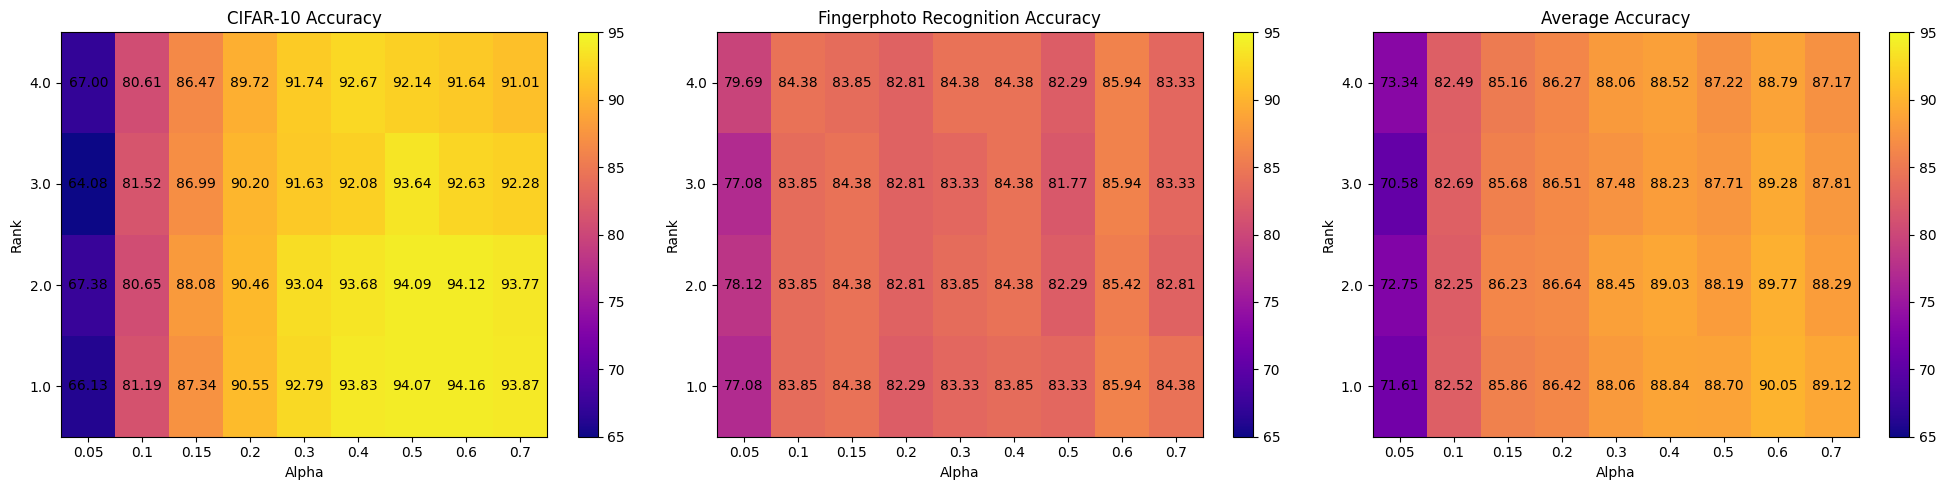

In [ ]:
vmin = 65
vmax = 95

x_coords = []
y_coords = []
values1 = []
values2 = []

for key, (value1, value2) in accuracy_dict.items():
    x, y = map(float, key.split(' - '))
    x_coords.append(x)
    y_coords.append(y)
    values1.append(value1)
    values2.append(value2*100)

# Unique coordinates for the heatmap axes
x_unique = sorted(set(x_coords))
y_unique = sorted(set(y_coords))

# Create empty matrices for heatmaps
heatmap1 = np.zeros((len(y_unique), len(x_unique)))
heatmap2 = np.zeros((len(y_unique), len(x_unique)))
heatmap_avg = np.zeros((len(y_unique), len(x_unique)))

# Fill the matrices with values
for i, (x, y, value1, value2) in enumerate(zip(x_coords, y_coords, values1, values2)):
    x_idx = x_unique.index(x)
    y_idx = y_unique.index(y)
    heatmap1[y_idx, x_idx] = value1
    heatmap2[y_idx, x_idx] = value2
    heatmap_avg[y_idx, x_idx] = (value1 + value2) / 2

# Plot heatmaps
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

# Heatmap for the first values
c1 = axs[0].imshow(heatmap1, aspect='auto', origin='lower', cmap='plasma', vmin=vmin, vmax=vmax)
axs[0].set_title('CIFAR-10 Accuracy')
axs[0].set_xticks(np.arange(len(x_unique)))
axs[0].set_yticks(np.arange(len(y_unique)))
axs[0].set_xticklabels(x_unique)
axs[0].set_yticklabels(y_unique)
axs[0].set_xlabel('Alpha')
axs[0].set_ylabel('Rank')
plt.colorbar(c1, ax=axs[0])

# Annotate heatmap with the values
for i in range(len(y_unique)):
    for j in range(len(x_unique)):
        axs[0].text(j, i, f'{heatmap1[i, j]:.2f}', ha='center', va='center', color='black')


# Heatmap for the second values
c2 = axs[1].imshow(heatmap2, aspect='auto', origin='lower', cmap='plasma', vmin=vmin, vmax=vmax)
axs[1].set_title('Fingerphoto Recognition Accuracy')
axs[1].set_xticks(np.arange(len(x_unique)))
axs[1].set_yticks(np.arange(len(y_unique)))
axs[1].set_xticklabels(x_unique)
axs[1].set_yticklabels(y_unique)
axs[1].set_xlabel('Alpha')
axs[1].set_ylabel('Rank')
plt.colorbar(c2, ax=axs[1])

for i in range(len(y_unique)):
    for j in range(len(x_unique)):
        axs[1].text(j, i, f'{heatmap2[i, j]:.2f}', ha='center', va='center', color='black')

# Heatmap for the average values
c3 = axs[2].imshow(heatmap_avg, aspect='auto', origin='lower', cmap='plasma', vmin=vmin, vmax=vmax)
axs[2].set_title('Average Accuracy')
axs[2].set_xticks(np.arange(len(x_unique)))
axs[2].set_yticks(np.arange(len(y_unique)))
axs[2].set_xticklabels(x_unique)
axs[2].set_yticklabels(y_unique)
axs[2].set_xlabel('Alpha')
axs[2].set_ylabel('Rank')
plt.colorbar(c3, ax=axs[2])

for i in range(len(y_unique)):
    for j in range(len(x_unique)):
        axs[2].text(j, i, f'{heatmap_avg[i, j]:.2f}', ha='center', va='center', color='black')


plt.subplots_adjust(wspace=0.3)
plt.tight_layout()
plt.show()

The result is much more satisfactory now. The combined multi-task model is able to achieve decent performance on both tasks. Remember that we only applied task vector addition to the backbone ResNet-18 and only trained several thousands parameters for just 1 epoch on CIFAR-10.

Observe the best average performance of 90.05% for rank = 1 and alpha = 0.6, when the adapter only had 2000 parameters (the adapter has low-rank matrices A and B, of shapes 1000x1 and 1x1000 respectively, amounting to 2000 parameters).